In [20]:
import pandas as pd
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
file_path = 'ucl.csv'
data = pd.read_csv(file_path)

In [22]:
print(data.head())

       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable  


In [23]:
print(data.isnull().sum())

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64


In [24]:
data = data.dropna()

In [25]:
X = data.drop(columns=['stabf'])  # 'stabf' is the column for stability
y = data['stabf']  # 'stabf' contains 'stable' or 'unstable'

In [26]:
# Step 6: Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [27]:
# Check for class imbalance
class_distribution = pd.Series(y_encoded).value_counts()
print("Class distribution:\n", class_distribution)

Class distribution:
 1    6380
0    3620
Name: count, dtype: int64


In [28]:
# Step 7: Normalize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
# Step 8: Apply PCA for dimensionality reduction (if needed)
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

In [30]:
# Step 9: Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_encoded)

In [31]:
# Step 10: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


# Step 11: Initialize TPOT with reduced search space and cross-validation
tpot_config = {
    'sklearn.neural_network.MLPClassifier': {
        'hidden_layer_sizes': [(100,), (50,), (100, 50)],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 300]
    },
    # Add other classifiers you want to include in the TPOT search space
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    },
    'sklearn.svm.SVC': {
        'kernel': ['linear', 'rbf'],
        'C': [1, 10]
    },
}

# Step 11: Initialize TPOT with reduced search space and cross-validation
tpot = TPOTClassifier(verbosity=2, generations=5, population_size=20, random_state=42,
                      config_dict=tpot_config, cv=5)

In [32]:
# Step 12: Train the model using TPOT
tpot.fit(X_train, y_train)

                                                                               
Generation 1 - Current best internal CV score: 0.984227210932015
                                                                               
Generation 2 - Current best internal CV score: 0.984227210932015
                                                                             
Generation 3 - Current best internal CV score: 0.984227210932015
                                                                                
Generation 4 - Current best internal CV score: 0.984227210932015
                                                                                
Generation 5 - Current best internal CV score: 0.984227210932015
                                                                                
Best pipeline: SVC(input_matrix, C=10, kernel=rbf)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'max_features': ['auto',
                                                                                         'sqrt',
                                                                                         'log2'],
                                                                        'min_samples_leaf': [1,
                                                                                             2],
                                                                        'min_samples_split': [2,
                                                                                              5],
                                                                        'n_estimators': [100,
                                                                                         200]},
                            'sklearn.neural_network.MLPClassifier': {'activation': ['tanh',
                                                                                    'relu'],
                                                                     'alpha': [0.0001,
                                                                               0.05],
                                                                     'hidden_layer_sizes': [(100,),
                                                                                            (50,),
                                                                                            (100,
                                                                                             50)],
                                                                     'learning_rate': ['constant',
                                                                                       'adaptive'],
                                                                     'max_iter': [200,
                                                                                  300],
                                                                     'solver': ['sgd',
                                                                                'adam']},
                            'sklearn.svm.SVC': {'C': [1, 10],
                                                'kernel': ['linear', 'rbf']}},
               generations=5, population_size=20, random_state=42, verbosity=2)

In [33]:
# Step 13: Evaluate on test data
y_pred = tpot.predict(X_test)

In [34]:
# Step 14: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

Test set accuracy: 0.9862852664576802


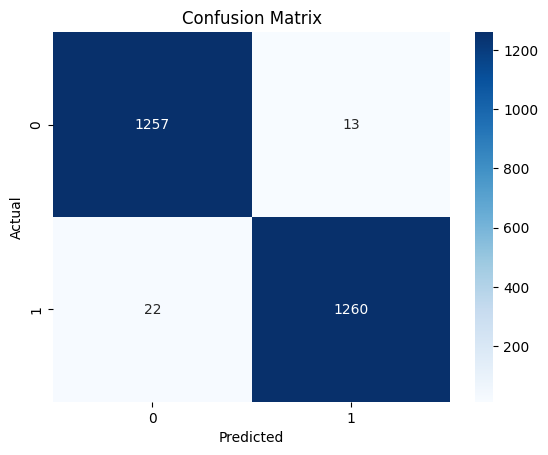

In [35]:
# Optional: Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Optional: Get classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1270
           1       0.99      0.98      0.99      1282

    accuracy                           0.99      2552
   macro avg       0.99      0.99      0.99      2552
weighted avg       0.99      0.99      0.99      2552



In [37]:
# Optional: Print the best pipeline found by TPOT
print("Best pipeline steps:", tpot.fitted_pipeline_)

Best pipeline steps: Pipeline(steps=[('svc', SVC(C=10, random_state=42))])
